In [172]:

from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import confusion_matrix
import numpy as np

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree as tr
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
#import seaborn as sns

from matplotlib import pyplot as plt



In [173]:
#### DATA PREP #####

train = pd.read_csv("/Users/annadaugaard/Downloads/archive-2/train.csv")
test = pd.read_csv("/Users/annadaugaard/Downloads/archive-2/test.csv")
# Bind it together, as we are not sure how this split was made
data = pd.concat([train, test])
# Mapping function
sentiment_map = {'neutral or dissatisfied': 0, 'satisfied': 1}
data['satisfaction'] = data['satisfaction'].map(sentiment_map)
data = data.dropna()

all_features = [
    'Inflight wifi service',
    'Ease of Online booking',
    'Food and drink',
    'Online boarding',
    'Seat comfort',
    'Inflight entertainment',
    'On-board service',
    'Leg room service',
    'Baggage handling',
    'Checkin service',
    'Inflight service',
    'Cleanliness',
    'Departure Delay in Minutes',
    'Arrival Delay in Minutes',
]

X= data[all_features]

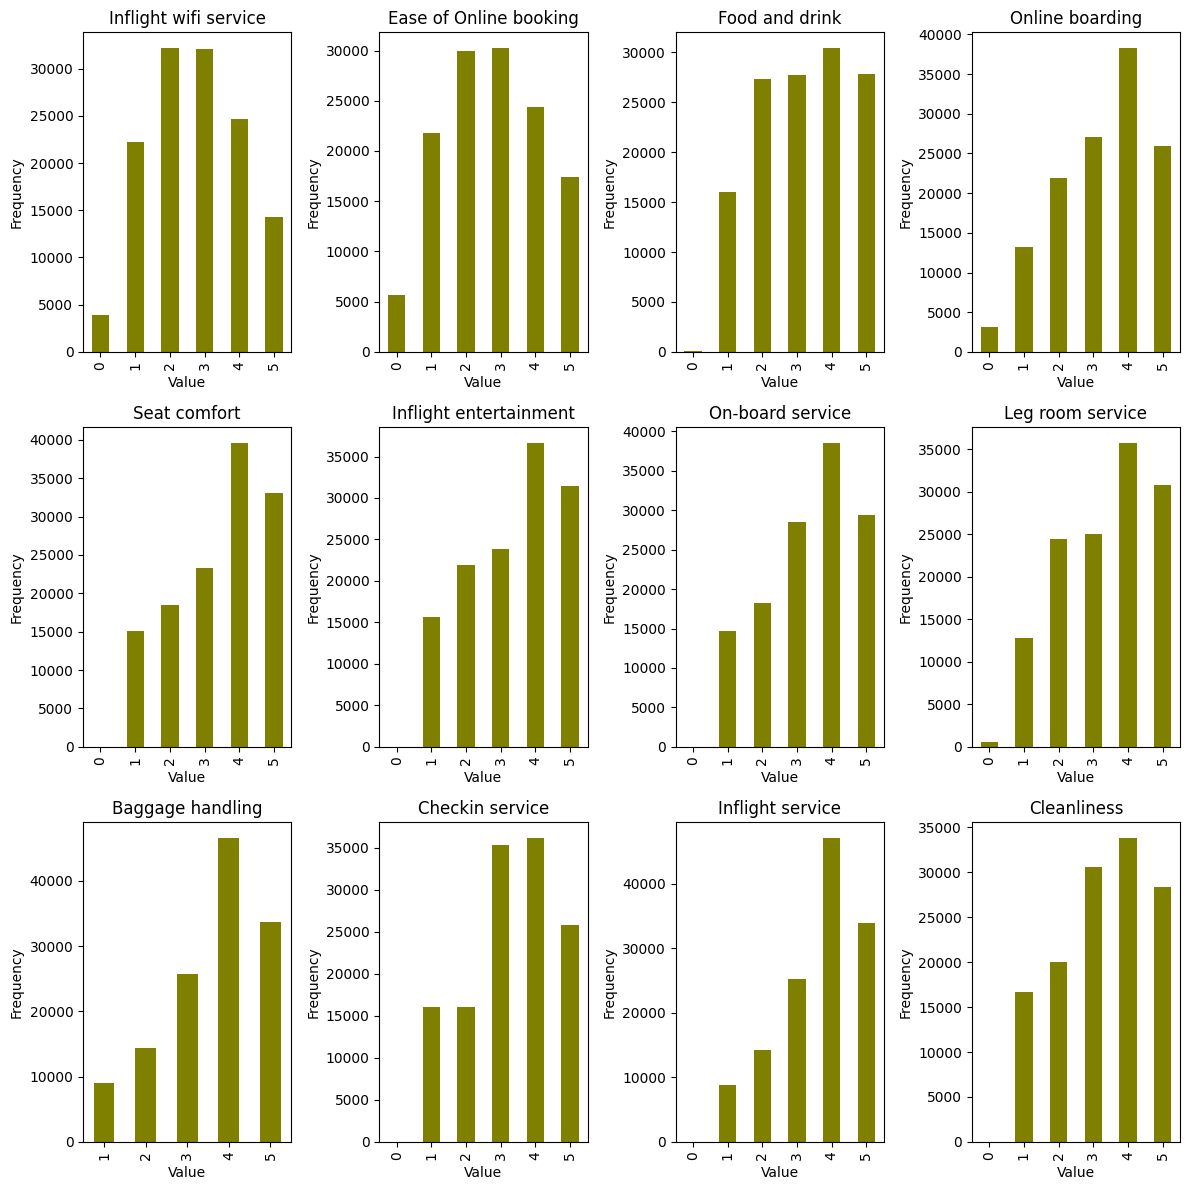

In [32]:
# Define grid layout
num_rows = 3
num_cols = 4
total_plots = 12

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 12))

# Flatten axes for easy indexing
axes = axes.flatten()
# Flatten axes for easy indexing
axes = axes.flatten()

# Plot each feature
for i, column in enumerate(X.columns[:total_plots]):
    X[column].value_counts().sort_index().plot(kind='bar', ax=axes[i], color='olive')
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    axes[i].set_title(f'{column}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Hide any remaining empty subplots 
for i in range(total_plots, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()



In [174]:

# Assuming you have your data stored in a variable X with shape (n_samples, n_features)
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA()
pca.fit(X_scaled)

# Analyze explained variance
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = explained_variance_ratio.cumsum()
#print("Cumulative explained variance:", cumulative_variance)

# Determine the number of components to include based on explained variance
# You can set a threshold or choose a number of components that explain a certain percentage of variance
n_components_to_include = np.argmax(cumulative_variance >= 0.95) 
print("Number of components to include:", n_components_to_include)

# Select the first n_components_to_include principal components
X_pca = pca.transform(X_scaled)[:, :n_components_to_include]


Number of components to include: 10


In [175]:
y = data["satisfaction"]

In [250]:
sum(y)

56262

In [176]:
# Split the data into training and testing sets
X_train, _x, y_train, _y = train_test_split(X_pca, y, test_size=0.3, random_state=42)

X_eval, X_test, y_eval, y_test = train_test_split(_x, _y , test_size=0.5, random_state=42) # 0.25 x 0.8 = 0.2


In [177]:

# Initialize logistic regression model
logistic_regression = LogisticRegression()

# Train the model on the training data
logistic_regression.fit(X_train, y_train)

# Predict on the testing data
y_pred = logistic_regression.predict(X_eval)

# Calculate accuracy
accuracy = accuracy_score(y_eval, y_pred)
F1_score = f1_score(y_eval, y_pred)
print("Accuracy:", accuracy, "F1:", F1_score)

Accuracy: 0.8065695309684395 F1: 0.7740693968368513


In [178]:
# Assuming you have already computed the confusion matrix
conf_matrix = np.array([[9892, 1763], [2214, 6850]])  # Replace TN, FP, FN, TP with actual values

# Get total number of samples
total_samples = np.sum(conf_matrix)

# Compute confusion matrix with percentages
conf_matrix_percent = conf_matrix / total_samples * 100

print("Confusion Matrix (Percentages):")
print(conf_matrix_percent)


Confusion Matrix (Percentages):
[[47.74361697  8.50909793]
 [10.68584391 33.06144119]]


In [179]:
def _compute_variance(pred):
    return pred.var(axis=1).mean()

def _compute_bias(pred, true):
    mpred = pred.mean(axis=1)
    return (((true - mpred)**2)).mean()

In [253]:

max_depth = 12 # this defines the most complex model we will fit (with x, ..., x^10) as inputs
n_sim = 100 # this defines how many times we do bootstrapping
performances = [] # here we will store performances
results = [] # here we store performances as a DF (see logic in the loop)
outputs = ['mtype', # this is the information we want to store in the DF
           'complexity', 
           'bias^2', 
           'variance',
           'f1_scores']

for c in range(1, max_depth):
    print(c)
    classifier = DecisionTreeClassifier(max_depth=c,class_weight='balanced',random_state=0) # initialize the model 
    pred_all = np.zeros(shape=(y_eval.shape[0], n_sim)) # empty array, which will store our predictions across bootstraps
    all_f1 = []
    for sim in range(n_sim): # bootstrap n_sim times
        x_trains, _, y_trains, _ = train_test_split(X_train, y_train, train_size=.7) # sample half of the data
        classifier.fit(x_trains,y_trains) # fit the model
        preds = classifier.predict(X_eval) # predict the outcomes
        pred_all[:,sim] = preds # store that in the big result matrix
       # print(f1_score(y_eval,preds))
        all_f1.append(f1_score(y_eval,preds))
    bias = _compute_bias(pred_all, y_eval) # get bias
    variance = _compute_variance(pred_all) # get variance
    f1_scores = mean(all_f1)
    info = ('tree', c, bias, variance, f1_scores)
    performances.append(info) # append model info to performances
    

# Getting the results into a dataframe 
result = pd.DataFrame(performances, columns=outputs)
for c in ['bias^2', 'variance']:
    result[f'{c}-scaled'] = MinMaxScaler().fit_transform(result[c].values.reshape(-1,1)) # rescale, so bias and variance are on the same scale
results.append(result)
performances = []

1
2
3
4
5
6
7
8
9
10
11


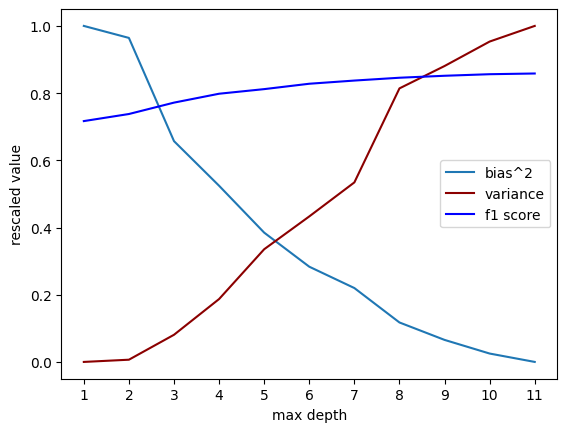

In [254]:
# Assuming results is a list of DataFrames
result_data = pd.concat(results)
result_data['complexity'] = result_data['complexity'].astype('category')

plt.plot(result_data['complexity'], result_data['bias^2-scaled'], label='bias^2')
plt.plot(result_data['complexity'], result_data['variance-scaled'], label='variance', color='darkred')
plt.plot(result_data['complexity'], result_data['f1_scores'], label='f1 score', color='blue')
#plt.plot(data['complexity'], data['mse-scaled'], label='MSE', color='grey')

plt.xlabel('max depth')
plt.ylabel('rescaled value')

# Adding a vertical line at the minimum MSE complexity

#plt.axvline(x=min_mse_complexity, linestyle='--', color='grey')
# Set the x-ticks to show all categories
plt.xticks(result_data['complexity'].cat.categories)

plt.legend()
plt.show()

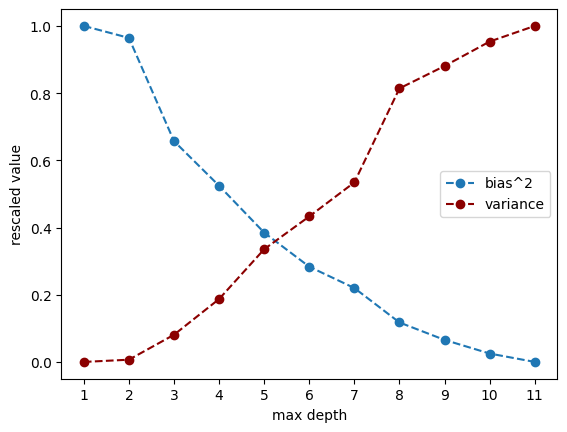

In [255]:
# Assuming results is a list of DataFrames
result_data = pd.concat(results)
result_data['complexity'] = result_data['complexity'].astype('category')


plt.plot(result_data['complexity'], result_data['bias^2-scaled'], label='bias^2', marker='o', linestyle='--')
plt.plot(result_data['complexity'], result_data['variance-scaled'], label='variance', color='darkred', marker='o', linestyle='--')
#plt.plot(result_data['complexity'], result_data['f1_scores'], label='f1 score', color='blue', marker='o', linestyle='--')

plt.xlabel('max depth')
plt.ylabel('rescaled value')

# Adding a vertical line at the minimum MSE complexity

#plt.axvline(x=min_mse_complexity, linestyle='--', color='grey')
# Set the x-ticks to show all categories
plt.xticks(result_data['complexity'].cat.categories)

plt.legend()
plt.show()

In [205]:
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

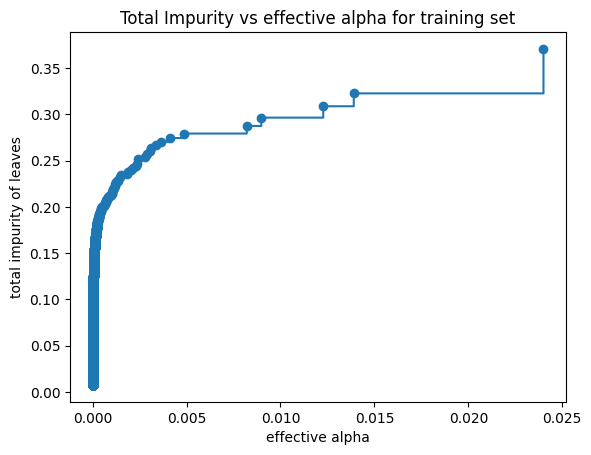

In [206]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [256]:
clfs = []

# Select the first n_components_to_include principal components
X_pca = pca.transform(X_scaled)[:, :n_components_to_include]
X_trains, X_tests, y_trains, y_tests = train_test_split(X_train, y_train, train_size=.5)

alpas = [0.0,0.000001,0.00013,0.00045]
alpas= np.linspace(0, 0.005, 20)
for ccp_alpha in alpas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha,class_weight='balanced')
    clf.fit(X_trains, y_trains)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)



Number of nodes in the last tree is: 17 with ccp_alpha: 0.12109877434283939


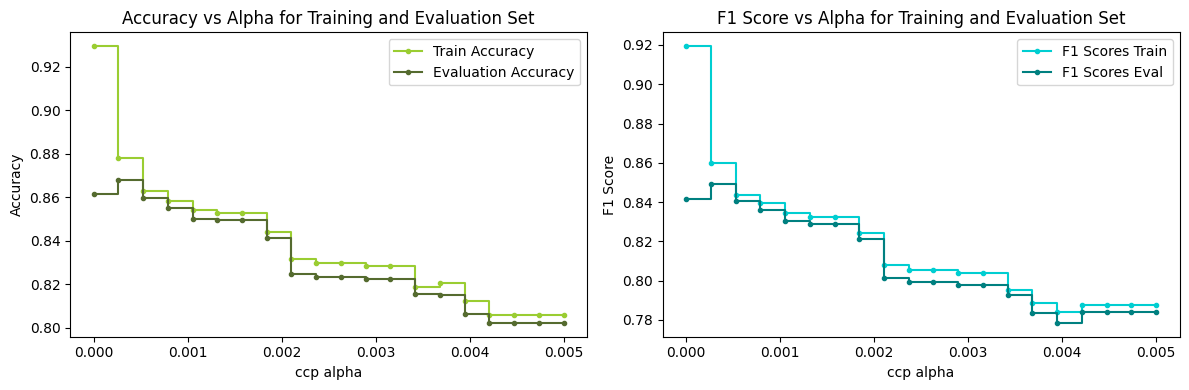

In [258]:
import matplotlib.pyplot as plt

train_scores = [clf.score(X_train, y_train) for clf in clfs]
evaluation_scores = [clf.score(X_eval, y_eval) for clf in clfs]
f1_scores_train = [f1_score(clf.predict(X_train), y_train) for clf in clfs]
f1_scores_eval = [f1_score(clf.predict(X_eval), y_eval) for clf in clfs]

# Create a figure and axes for subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot train_scores and evaluation_scores together
axes[0].plot(alpas, train_scores, marker="o",markersize=3, label="Train Accuracy", drawstyle="steps-post",color='yellowgreen')
axes[0].plot(alpas, evaluation_scores, marker="o", markersize=3,label="Evaluation Accuracy", drawstyle="steps-post",color='darkolivegreen')
axes[0].set_xlabel("ccp alpha")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Accuracy vs Alpha for Training and Evaluation Set")
axes[0].legend()

# Plot f1_scores_train and f1_scores_eval together
axes[1].plot(alpas, f1_scores_train, marker="o", markersize=3, label="F1 Scores Train", drawstyle="steps-post", color = 'darkturquoise')
axes[1].plot(alpas, f1_scores_eval, marker="o",markersize=3, label="F1 Scores Eval", drawstyle="steps-post", color = 'teal')
axes[1].set_xlabel("ccp alpha")
axes[1].set_ylabel("F1 Score")
axes[1].set_title("F1 Score vs Alpha for Training and Evaluation Set")
axes[1].legend()


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

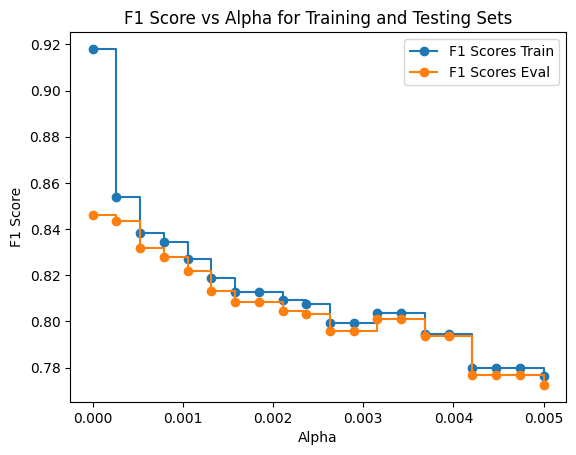

In [223]:

plt.plot(alpas, f1_scores_train, marker="o", label="F1 Scores Train", drawstyle="steps-post")
plt.plot(alpas, f1_scores_eval, marker="o", label="F1 Scores Eval", drawstyle="steps-post")
plt.xlabel("Alpha")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Alpha for Training and Testing Sets")
plt.legend()
plt.show()

In [272]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint, uniform
import numpy as np

# Define the parameter grid
param_grid = {
    'max_depth': randint(3, 9),          # Range for tree depth
    'ccp_alpha': np.linspace(0,0.002,20)   # Specific values for ccp_alpha
}

# Create the decision tree classifier
dt_classifier = DecisionTreeClassifier(random_state=0,class_weight='balanced')

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=dt_classifier, param_distributions=param_grid, n_iter=50, cv=5, random_state=42)

# Perform Randomized Grid Search CV
random_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = random_search.best_params_
#best_score = random_search.best_score_

print("Best Parameters:", best_params)
#print("Best Score:", best_score)

Best Parameters: {'ccp_alpha': 0.00010526315789473685, 'max_depth': 8}
Best Score: 0.8660856134157106


In [282]:

# Create the decision tree classifier
dt_classifier_final = DecisionTreeClassifier(random_state=0,ccp_alpha=0.00010526315789473685, max_depth= 8, class_weight='balanced')
dt_classifier_final.fit(X_train,y_train)
accuracy_score(dt_classifier_final.predict(X_eval),y_eval)
#f1_score(dt_classifier_final.predict(X_eval),y_eval)

0.8662410544200175

In [285]:
y_pred = dt_classifier_final.predict(X_eval)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_eval, y_pred)

# Assuming you have already computed the confusion matrix
conf_matrix = np.array(conf_matrix)  # Replace TN, FP, FN, TP with actual values

# Get total number of samples
total_samples = np.sum(conf_matrix)

# Compute confusion matrix with percentages
conf_matrix_percent = conf_matrix / total_samples * 100

print("Confusion Matrix (Percentages):")
print(conf_matrix_percent)

Confusion Matrix (Percentages):
[[49.13247181  7.54775266]
 [ 5.82814189 37.49163363]]


In [368]:
new_pca_components=[]

for importance, component in zip(dt_classifier_final.feature_importances_,abs(pca.components_)):
    new_pca_components.append(component*importance)

mean_weights = np.mean(new_pca_components, axis=0)
mean_weights

array([0.02936593, 0.02754769, 0.02781378, 0.03208313, 0.02714205,
       0.02715911, 0.02105195, 0.01778826, 0.01837445, 0.01545777,
       0.01854521, 0.02507103, 0.00341589, 0.00352903])

In [375]:
# Get the indices of the features sorted by importance
sorted_indices = mean_weights.argsort()[::-1] 

sorted_indices

array([ 3,  0,  2,  1,  5,  4, 11,  6, 10,  8,  7,  9, 13, 12])

In [377]:
# Create a dictionary with feature names as keys and values ranging from 0 to 14
feature_dict = {i: feature for i, feature in enumerate(all_features)}
for i in sorted_indices:
    print(feature_dict[i])

Online boarding
Inflight wifi service
Food and drink
Ease of Online booking
Inflight entertainment
Seat comfort
Cleanliness
On-board service
Inflight service
Baggage handling
Leg room service
Checkin service
Arrival Delay in Minutes
Departure Delay in Minutes


In [381]:
import xgboost as xgb


# Instantiate XGBoost classifier
clf_boost = xgb.XGBClassifier(random_state=0,max_depth= 8)

# Train the model
clf_boost.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf_boost.predict(X_eval)

# Evaluate the model
accuracy = accuracy_score(y_eval, y_pred)
f1 = f1_score(y_eval, y_pred)
print("Accuracy:", accuracy, "f1", f1)

Accuracy: 0.9125263862431139 f1 0.8978904982270569


In [382]:
# Make predictions on the test set
y_pred = clf_boost.predict(X_eval)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_eval, y_pred)

# Assuming you have already computed the confusion matrix
conf_matrix = np.array(conf_matrix)  # Replace TN, FP, FN, TP with actual values

# Get total number of samples
total_samples = np.sum(conf_matrix)

# Compute confusion matrix with percentages
conf_matrix_percent = conf_matrix / total_samples * 100

print("Confusion Matrix (Percentages):")
print(conf_matrix_percent)

Confusion Matrix (Percentages):
[[52.79308037  3.88714411]
 [ 4.86021727 38.45955826]]


In [383]:
new_pca_components=[]

for importance, component in zip(clf_boost.feature_importances_,abs(pca.components_)):
    new_pca_components.append(component*importance)

mean_weights = np.mean(new_pca_components, axis=0)
mean_weights

array([0.0224067 , 0.02087761, 0.02665398, 0.02955202, 0.0250887 ,
       0.02208432, 0.02274073, 0.01957349, 0.02151428, 0.01678354,
       0.02124544, 0.02090861, 0.00443061, 0.00448837])

In [384]:
# Create a dictionary with feature names as keys and values ranging from 0 to 14
feature_dict = {i: feature for i, feature in enumerate(all_features)}
for i in sorted_indices:
    print(feature_dict[i])

Online boarding
Inflight wifi service
Food and drink
Ease of Online booking
Inflight entertainment
Seat comfort
Cleanliness
On-board service
Inflight service
Baggage handling
Leg room service
Checkin service
Arrival Delay in Minutes
Departure Delay in Minutes
